In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score, roc_auc_score

In [2]:
f = open('dataset.json')
data = json.load(f)
file = 'best_algorithm.sav'
best_algorithm = pickle.load(open(file, "rb"))

In [3]:
cleaned_dataset = []

for k,v in data.items():
    
    individual_data = {}
    individual_data['post_tokens'] = v['post_tokens']
    individual_data['post_tokens_joined'] = ' '.join(v['post_tokens'])
    individual_data['target'] = v['annotators'][0]['target']
    individual_data['annotator_a_label'] = v['annotators'][0]['label']
    individual_data['annotator_b_label'] = v['annotators'][1]['label']
    individual_data['annotator_c_label'] = v['annotators'][2]['label']
    
    labels = [v['annotators'][0]['label'], v['annotators'][1]['label'], v['annotators'][2]['label']]
    final_label = max(labels, key=labels.count)
    individual_data['final_label'] = final_label
    
    if set(labels) != 3:
    
        if len(v['rationales']) == 0: 
            individual_data['annotator_a_rationale'] = []
            individual_data['annotator_b_rationale'] = []
            individual_data['annotator_c_rationale'] = []
            individual_data['final_rationale'] = []
            
        else:  
            individual_data['annotator_a_rationale'] = v['rationales'][0]
            individual_data['annotator_b_rationale'] = v['rationales'][1]
        
            if final_label != v['annotators'][1]['label']:
                individual_data['final_rationale'] = v['rationales'][0]
            else:
                individual_data['final_rationale'] = v['rationales'][1]
                       
        cleaned_dataset.append(individual_data)

In [4]:
df = pd.DataFrame(cleaned_dataset)
df.head()

,post_tokens,post_tokens_joined,target,annotator_a_label,annotator_b_label,annotator_c_label,final_label,annotator_a_rationale,annotator_b_rationale,annotator_c_rationale,final_rationale
0,"[i, dont, think, im, getting, my, baby, them, ...",i dont think im getting my baby them white 9 h...,[None],normal,normal,normal,normal,[],[],[],[]
1,"[we, cannot, continue, calling, ourselves, fem...",we cannot continue calling ourselves feminists...,[None],normal,normal,normal,normal,[],[],[],[]
2,"[nawt, yall, niggers, ignoring, me]",nawt yall niggers ignoring me,[African],normal,normal,hatespeech,normal,[],[],[],[]
3,"[<user>, i, am, bit, confused, coz, chinese, p...",<user> i am bit confused coz chinese ppl can n...,[Asian],hatespeech,offensive,hatespeech,hatespeech,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[this, bitch, in, whataburger, eating, a, burg...",this bitch in whataburger eating a burger with...,"[Caucasian, Women]",hatespeech,hatespeech,offensive,hatespeech,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)
df_train = df.loc[train_indices]
df_test = df.loc[test_indices]

In [6]:
X_train = df_train['post_tokens_joined']
y_train = df_train['final_label']
X_test = df_test['post_tokens_joined']
y_test = df_test['final_label']

vectorizer = TfidfVectorizer(norm="l2") 
X_train_vect = vectorizer.fit_transform(X_train, y_train)

In [7]:
X_test_target = df_test['target']

In [8]:
nested_list = X_test_target.tolist()
flattened_targets_list = [item for sublist in nested_list for item in sublist]
unique_targets_list = list(set(flattened_targets_list))

In [9]:
unique_targets_list

['Refugee',
 'Hispanic',
 'Nonreligious',
 'Minority',
 'Jewish',
 'African',
 'Asexual',
 'Heterosexual',
 'Indigenous',
 'Christian',
 'Caucasian',
 'Other',
 'Islam',
 'Economic',
 'Asian',
 'Women',
 'Men',
 'Arab',
 'Homosexual',
 'Indian',
 'Hindu',
 'Disability',
 'None']

In [10]:
data = {}
for target in unique_targets_list:
    data[target] = []

In [11]:
for idx, row in df_test.iterrows():
    for target in row['target']:
        data[target].append(idx)

In [12]:
roc_auc_performance = {}
for k,v in data.items():
    try:
        target = k
        indices = v
        X_test = df_test[df_test.index.isin(indices)]['post_tokens_joined']
        X_test_vect = vectorizer.transform(X_test)
        y_test = df_test[df_test.index.isin(indices)]['final_label']
        roc_auc = roc_auc_score(y_test, best_algorithm.predict_proba(X_test_vect), multi_class='ovr')
        print(roc_auc)
        roc_auc_performance[target] = roc_auc
    except:
        pass

0.674283903083849
0.7251058201058201
0.8015396873195648
0.7639578966184103
0.9194444444444446
0.8457977207977209
0.7142433962005827
0.7563127775617621
0.7207845147576323
0.7011605667394828
0.7828080438109625
0.8004306200629876
0.746628033570809
0.7470951225914056
0.7712962962962964
0.71511544011544
0.7854352780579307


In [13]:
roc_auc_performance.pop('None')

0.7854352780579307

In [15]:
roc_auc_performance = dict(sorted(roc_auc_performance.items(), key=lambda item: item[1]))

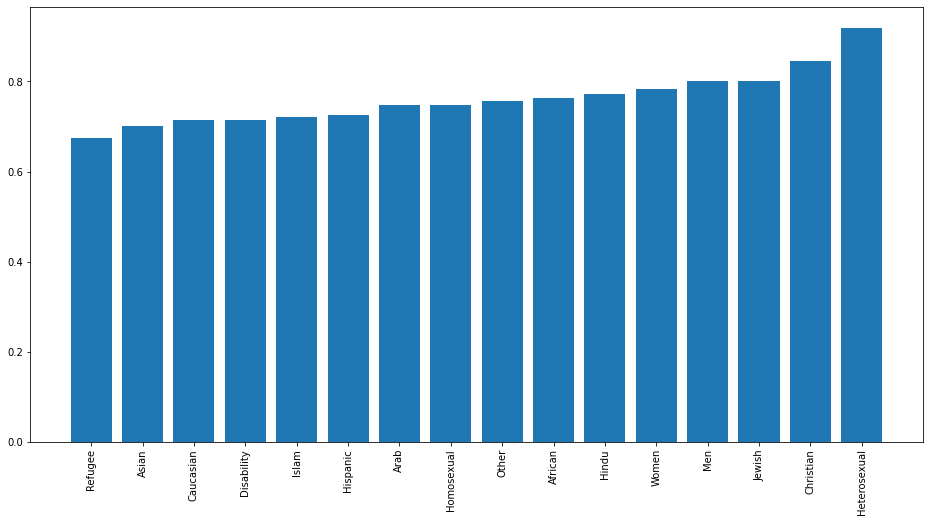

In [16]:
fig = plt.figure(figsize=(16, 8))
plt.bar(roc_auc_performance.keys(), roc_auc_performance.values())
plt.xticks(rotation=90)
plt.show()